<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
# Radar - Sentinel-1: ARD SAR Backscatter

This notebook has been duplicated from an existing sample processing pipeline for Radar ARD on the openEO platform. In this instance, we aim to showcase it with the Copernicus Data Space Ecosystem backend.

For more information [click here](https://docs.openeo.cloud/usecases/ard/).ess

## Setup

Import the `openeo` package and connect to the Copernicus Data Space Ecosystem openEO back-end.

In [38]:
import openeo

In [33]:
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()

Authenticated using refresh token.


### On-demand SAR Backscatter

Data from synthetic aperture radar (SAR) sensors requires significant preprocessing to be calibrated and normalized for terrain. This is referred to as backscatter computation and is provided in the openEO by

the [`sar_backscatter` process](https://docs.openeo.cloud/processes/#sar_backscatter)
and its CARD4L compliant variant, the [`ard_normalized_radar_backscatter process`](https://docs.openeo.cloud/processes/#ard_normalized_radar_backscatter)

The **ard_normalized_radar_backscatter** process computes **on-demand** backscatter from SAR input.

The radiometric correction coefficient used in this example is gamma0(ellipsoid).

## Specify area of interest, temporal extent, polarization

In [34]:
collection = "SENTINEL1_GRD"
spatial_extent = {
    "west": 11.293602,
    "east": 11.382866,
    "south": 46.460163,
    "north": 46.514768,
    "crs": "EPSG:4326",
}
temporal_extent = ["2021-01-01", "2021-01-08"]
bands = ["VV", "VH"]

properties = {
    "orbitDirection": lambda od: od == "ASCENDING"
}  ## Orbit direction filtering

s1 = conn.load_collection(
    collection,
    spatial_extent=spatial_extent,
    bands=bands,
    temporal_extent=temporal_extent,
    properties=properties,
)

## Apply openEO processes

Here we apply both the SAR backscattering processes on the datacube and then convert it from linear to dB scale.

In [35]:
s1_scatter = s1.sar_backscatter(coefficient="gamma0-ellipsoid")

In [36]:
s1bs_linear = s1_scatter.ard_normalized_radar_backscatter(
    elevation_model="COPERNICUS_30"
)
s1bs = s1bs_linear.apply(lambda x: 10 * x.log(base=10))

## Synchronous execution 

If our area of interest is small, a direct request is possible, but this will not return the JSON metadata.

Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [25]:
%time s1bs.download("sar_bs.nc",format="NetCDF")

CPU times: user 6.84 ms, sys: 23.4 ms, total: 30.2 ms
Wall time: 1min 11s


## Batch job-based execution

Save process as a final step; here, we use NetCDF as the output format. Now, we will create a batch job and start it.

In [21]:
s1bs_netcdf = s1bs.save_result(format="NetCDF")

In [37]:
job_bs = s1bs_netcdf.send_job(title="SAR_backscatter")
job_id_bs = job_bs.job_id
if job_id_bs:
    print("Batch job created with id: ", job_id_bs)
    job_bs.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  j-843e4af2ccd7481eb372fd85c7ff7728


Get a description of the job and check its status.

In [23]:
job_bs = conn.job(job_id_bs)
job_description = job_bs.describe_job()
print("Batch job with id: ", job_id_bs, " is ", job_description["status"])

Batch job with id:  j-757f525b553d4cd087ae4f8df0f05769  is  finished


Once the status is 'finished', it is possible to inspect the results. Download links are provided to retrieve data and metadata.

In [24]:
results = job_bs.get_results()
results

<JobResults for job 'j-757f525b553d4cd087ae4f8df0f05769'>

**Optional: download complete result with metadata and source files**

Results contain STAC metadata and the processed data. 

We can simply download everything, for inspection. Please note: this will download also the original S1 GRD files, which can take a lot of time for a big area or a timeseries.

In [ ]:
# results.download_files()

## Output visualization

In [29]:
import xarray as xr

S1_ard = xr.open_dataset("sar_bs.nc")
S1_ard

<xarray.Dataset>
Dimensions:  (t: 1, x: 704, y: 628)
Coordinates:
  * t        (t) datetime64[ns] 2021-01-03
  * x        (x) float64 6.759e+05 6.76e+05 6.76e+05 ... 6.83e+05 6.83e+05
  * y        (y) float64 5.154e+06 5.154e+06 5.154e+06 ... 5.148e+06 5.148e+06
Data variables:
    crs      |S1 ...
    VV       (t, y, x) float32 ...
    VH       (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

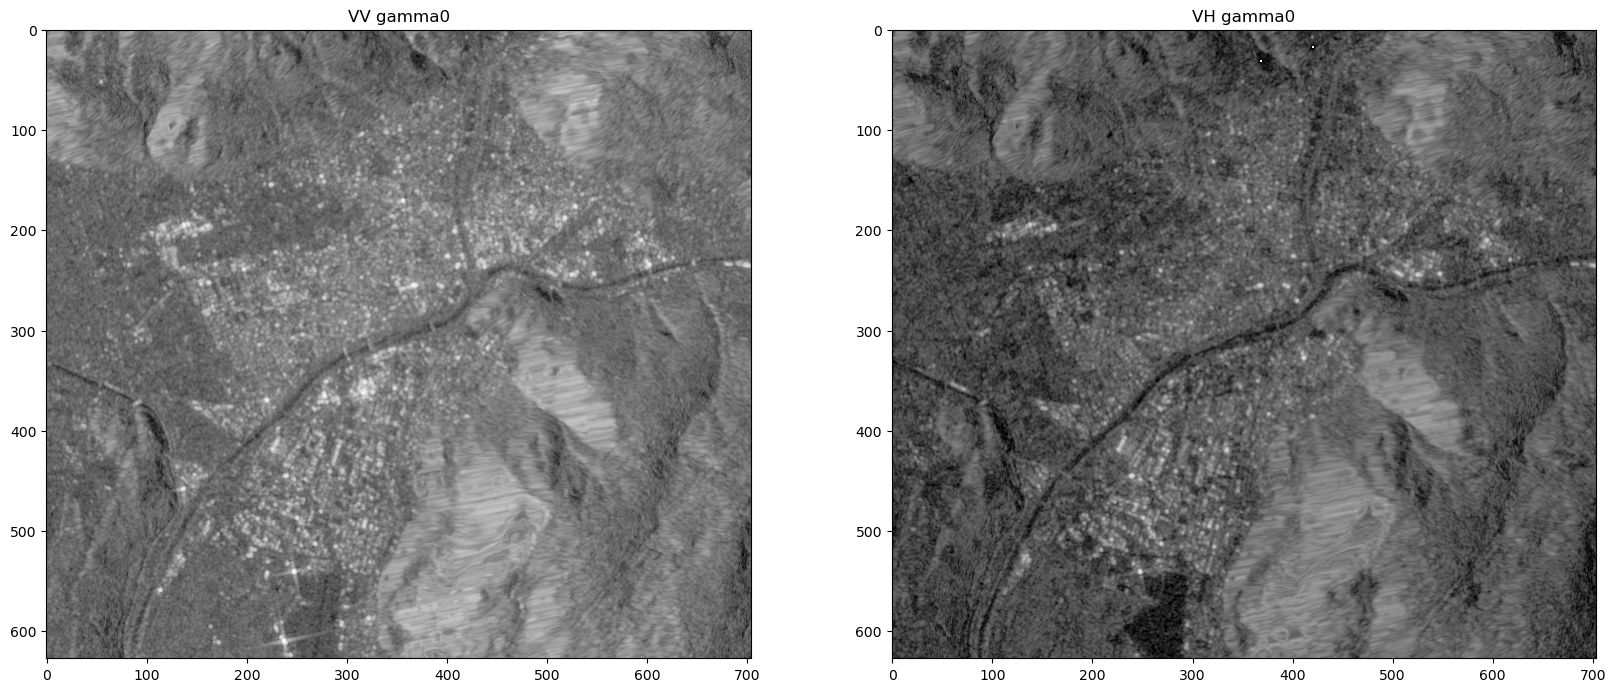

In [30]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(S1_ard.VV[0].values, cmap="Greys_r", vmin=-30, vmax=30)
ax1.set_title("VV gamma0")
ax2.imshow(S1_ard.VH[0].values, cmap="Greys_r", vmin=-30, vmax=30)
ax2.set_title("VH gamma0")
plt.show()

### Additional SAR processing capabilities:


The **sar_backscatter** process offers multiple parameters that can be used depending on the application needs: https://docs.openeo.cloud/processes/#sar_backscatter

We can choose among the following coefficients:
- **beta0**:            radar brightness
- **sigma0-ellipsoid**: ground area computed with an ellipsoid earth model
- **gamma0-ellipsoid**: ground area computed with ellipsoid earth model in sensor line of sight
- **null**:             non-normalized backscatter
